In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/projects/Opt4ML/batch-norm-helps-optimization

/content/drive/MyDrive/projects/Opt4ML/batch-norm-helps-optimization


# Base VGG training and testing

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

<ipython-input-1-1f0008edec47>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


## Constants (parameters) initialization

In [ ]:
device_id = 0
num_workers = 4

batch_size = 128
default_learning_rate = 0.1

## CIFAR-10 data load and preproc

In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import PIL.Image as Image
from torch import nn
import numpy as np
import torch.optim as optim
import pandas as pd
import torch
from torchvision import transforms, utils
import torchvision.models as models
import torchvision.datasets as datasets
import os
import sys
import random
from tqdm import tqdm as tqdm
from IPython import display
import seaborn as sns

In [ ]:
# add our package dir to path
module_path = os.path.dirname(os.getcwd())
sys.path.append(module_path)

home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

Make sure you are using the right device.

In [ ]:
device_id = device_id
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(device_id)

device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device_id))

cuda:0
Tesla T4


## Models implementation

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0)

class VanillaFFN(nn.Module):
    def __init__(self):
        super().__init__()
        self.blocks = torch.nn.ModuleList([nn.Sequential(nn.Linear(in_features=1024, out_features=1024),nn.ReLU()) for _ in range(9)]+[nn.Linear(1024, 1024)])
        [b.apply(init_weights) for b in self.blocks]

    def forward(self, x):
        outputs = []
        for i, l in enumerate(self.blocks):
            x = self.blocks[i](x)
            x.retain_grad()
            outputs.append(x)
        return outputs

class NormFFN(nn.Module):
    def __init__(self):
        super().__init__()

        self.blocks = torch.nn.ModuleList([nn.Sequential(nn.Linear(in_features=1024, out_features=1024),nn.BatchNorm1d(1024),nn.ReLU()) for _ in range(9)]+[nn.Linear(1024, 1024)])
        [b.apply(init_weights) for b in self.blocks]

    def forward(self, x):
        outputs = []
        for i, l in enumerate(self.blocks):
            x = self.blocks[i](x)
            x.retain_grad()
            outputs.append(x)
        return outputs

## Final preparations for training

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def set_random_seeds(seed_value=0, device = 'cpu'):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu':
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
def forward_pass(model):
    set_random_seeds(42, device)

    model.to(device)

    x0 = torch.normal(mean=np.random.rand(), std=1, size=(512, 1024)).to(device)
    y = model(x0)

    w = torch.normal(mean=0, std=1, size=(512, 1024)).to(device)
    l = torch.sum(y[-1]*w)
    l.backward()

    grads, layers, grad_mse = [], [], []
    for i, y_i in enumerate(y[:-1]):
        y_i = y_i.grad.cpu().reshape(-1).tolist()
        grads.extend(y_i)
        layers.extend(len(y_i)*[f"Layer {i+1}"])
        grad_mse.append(np.mean(np.array(y_i)**2))

    data = {"Gradient Magnitude": grads, "Layer": layers}
    df = pd.DataFrame(data)

    sns.displot(data, x="Gradient Magnitude", hue="Layer", kind="kde")
    plt.savefig(f"reports/figures/grad_magnitude_{model._get_name()}.png")
    plt.show()

    return np.array(grad_mse)

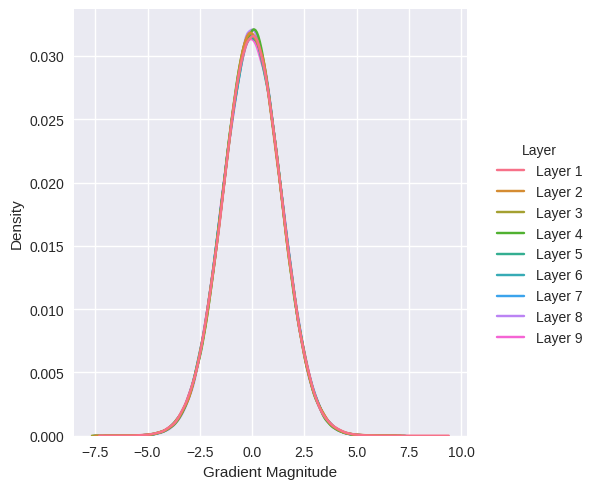

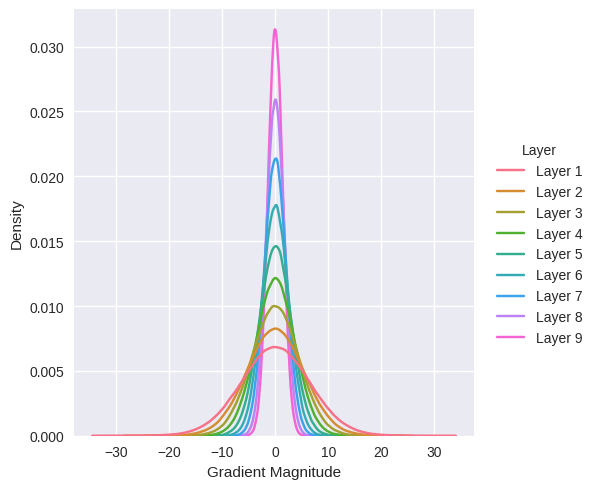

In [ ]:
vanilla_hist_width = forward_pass(VanillaFFN())
norm_hist_width = forward_pass(NormFFN())

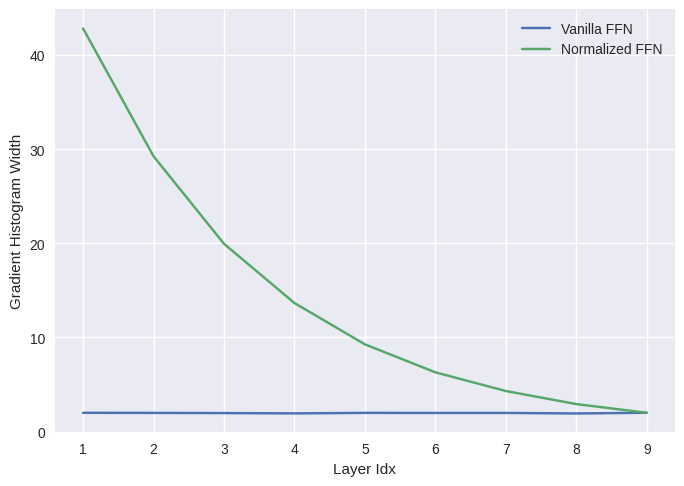

In [ ]:
plt.plot([f"{i+1}" for i in range(len(vanilla_hist_width))], vanilla_hist_width)
plt.plot([f"{i+1}" for i in range(len(norm_hist_width))], norm_hist_width)
plt.legend(["Vanilla FFN", "Normalized FFN"])
plt.xlabel("Layer Idx")
plt.ylabel("Gradient Histogram Width")
plt.savefig("reports/figures/histogram width.png")
plt.show()